In [4]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 7.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=bdff53798e531af3b8cb140b5c449d4260005ab60965bb4c764210e2bc62f84b
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [2]:
pip install kmodes


# K-prototypes - Customer Segmentation

In [14]:
# Load the dataset
df = pd.read_csv('Churn_Data_cleaned.csv')

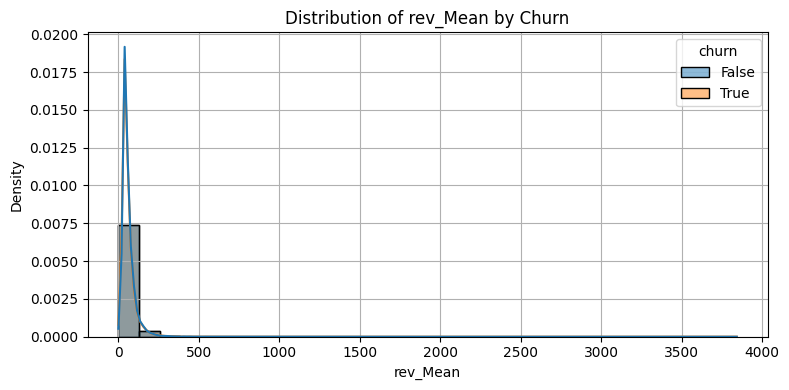

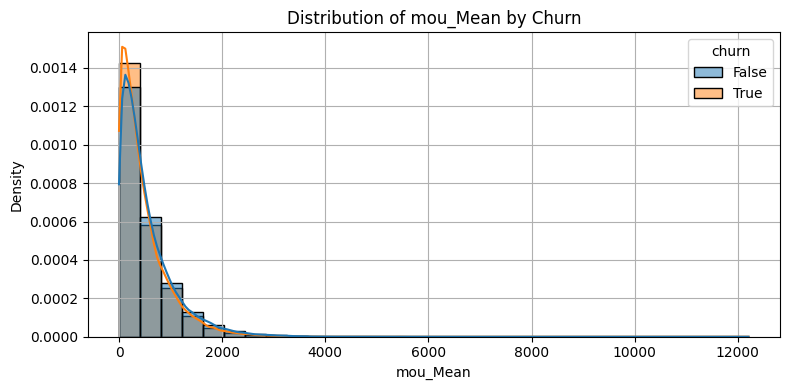

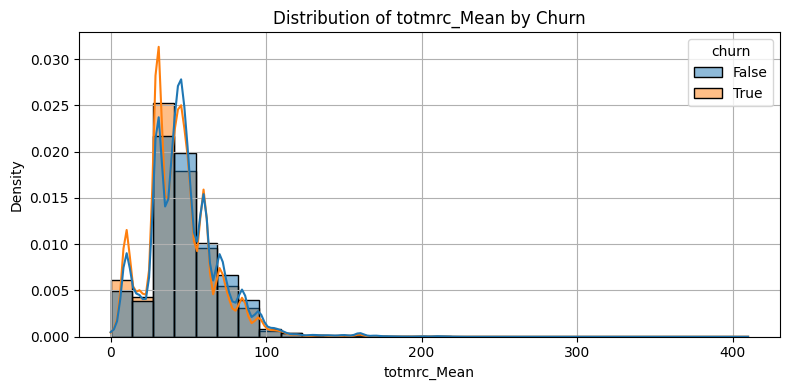

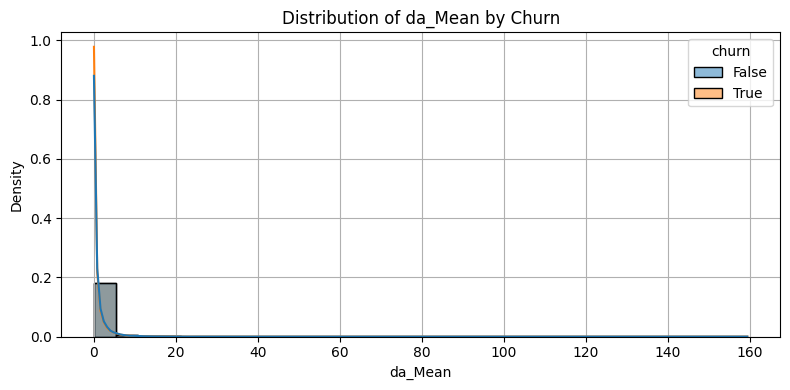

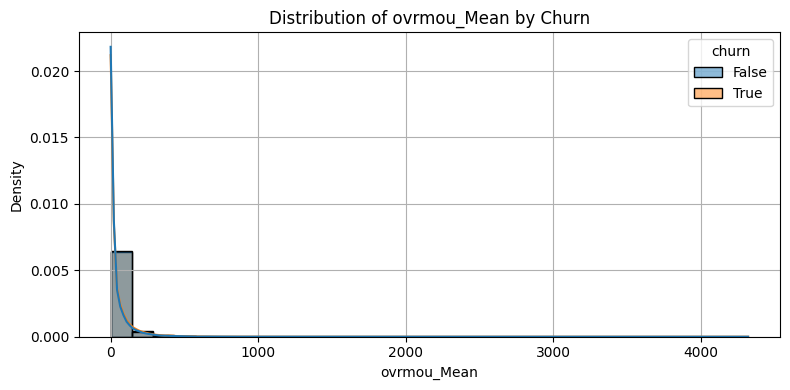

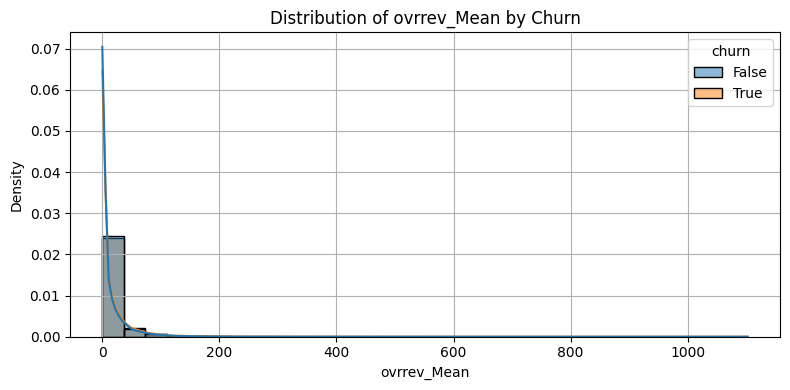

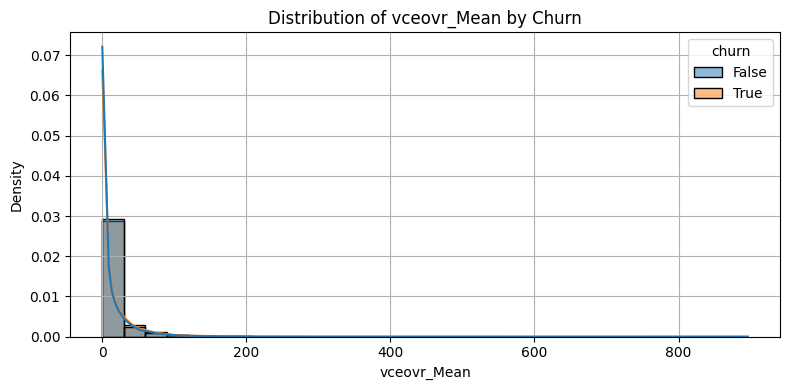

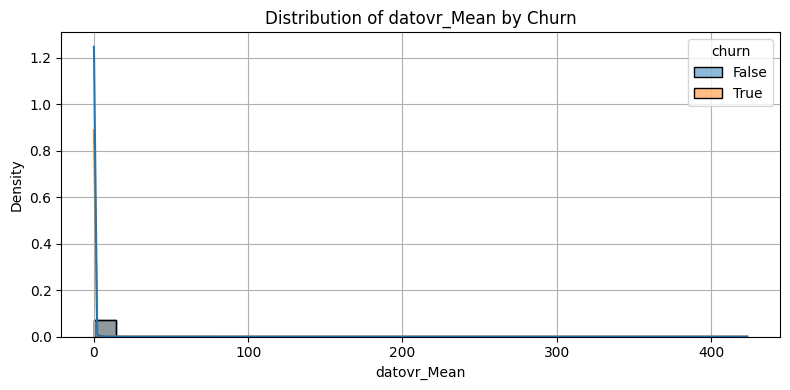

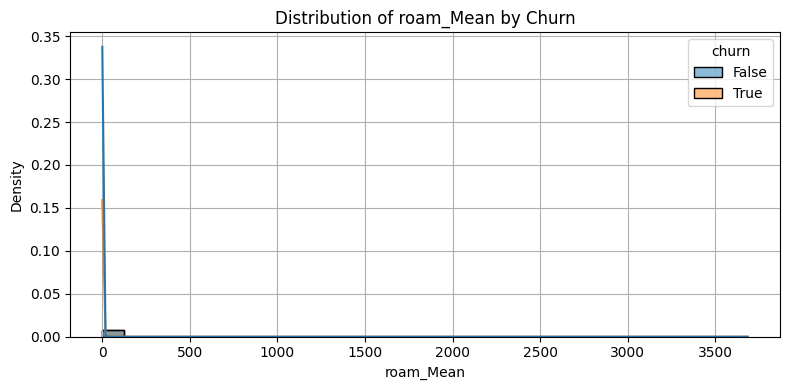

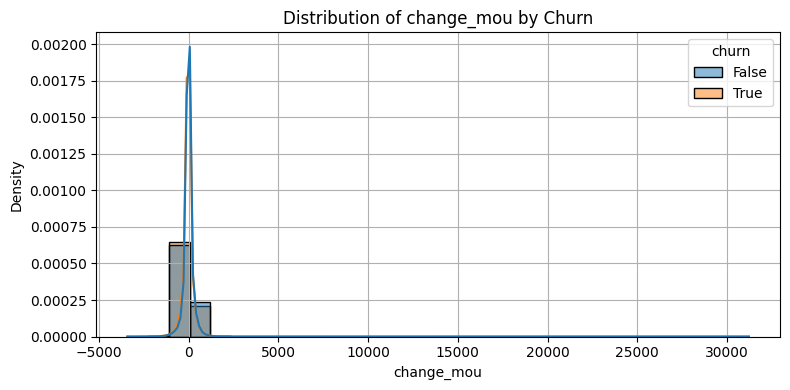

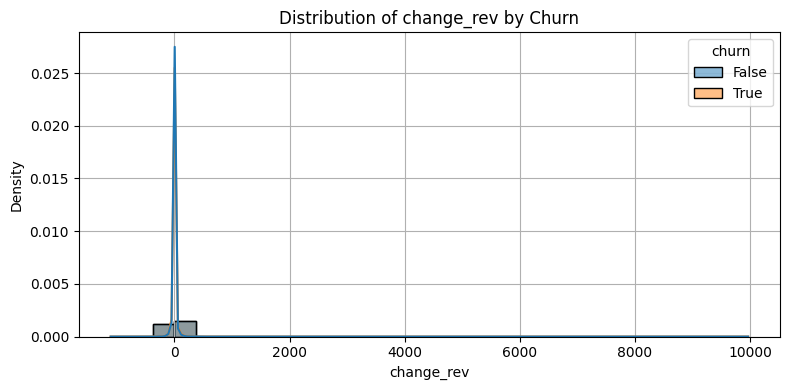

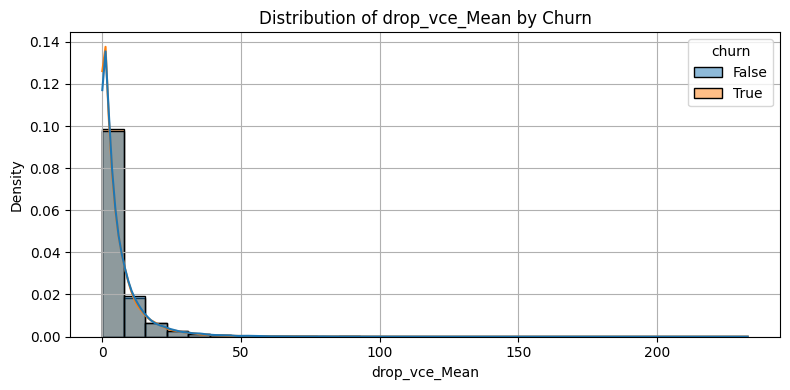

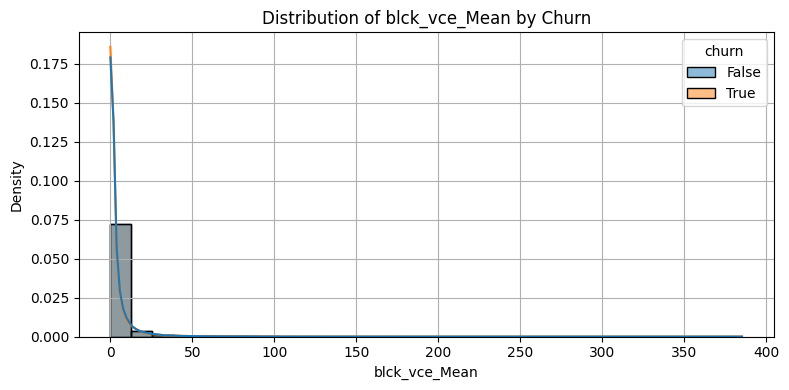

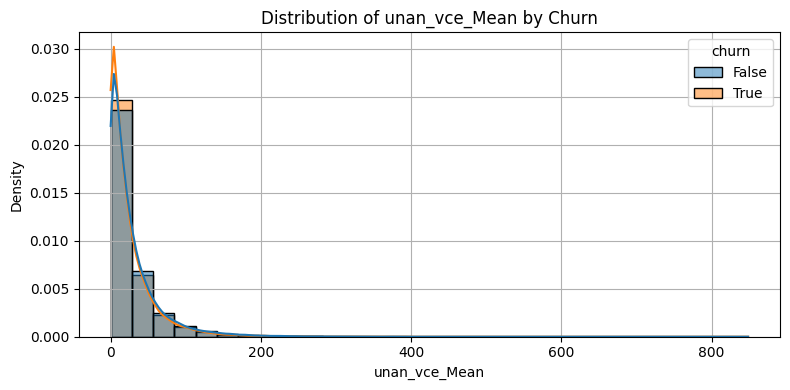

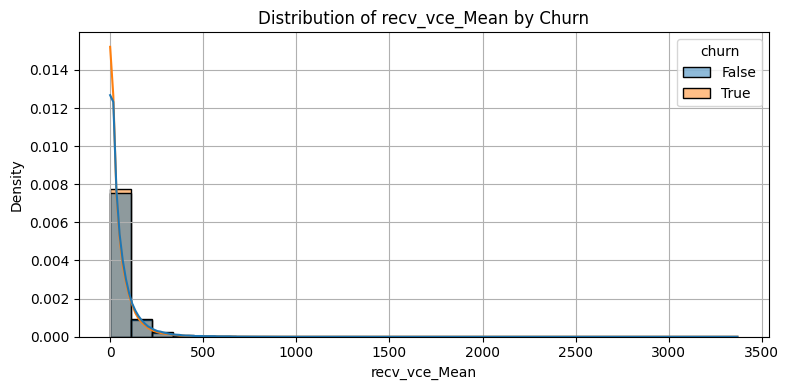

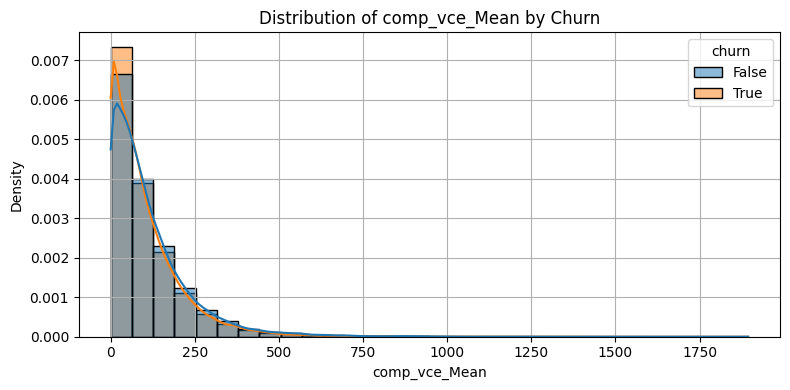

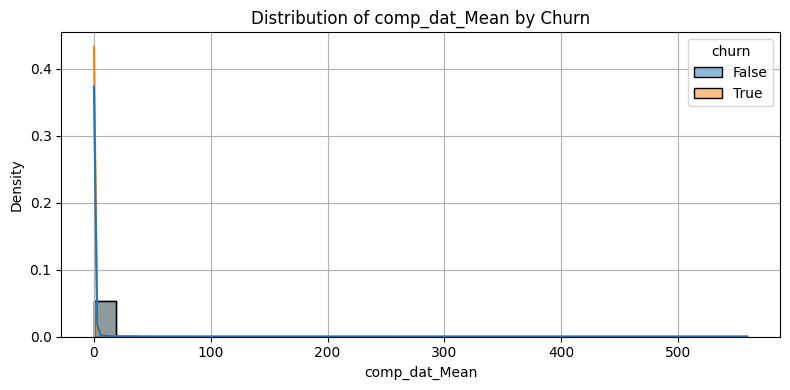

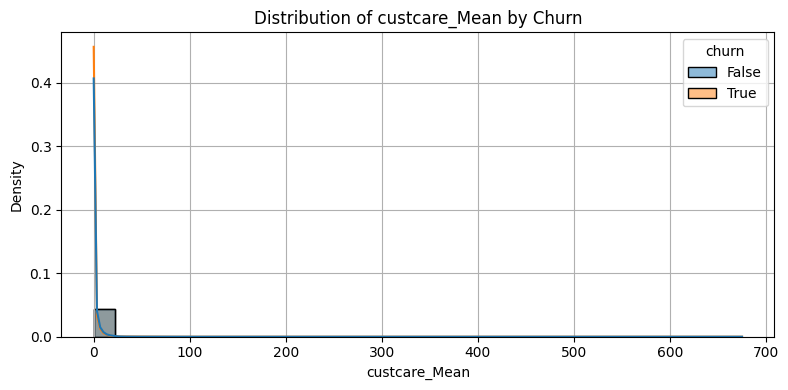

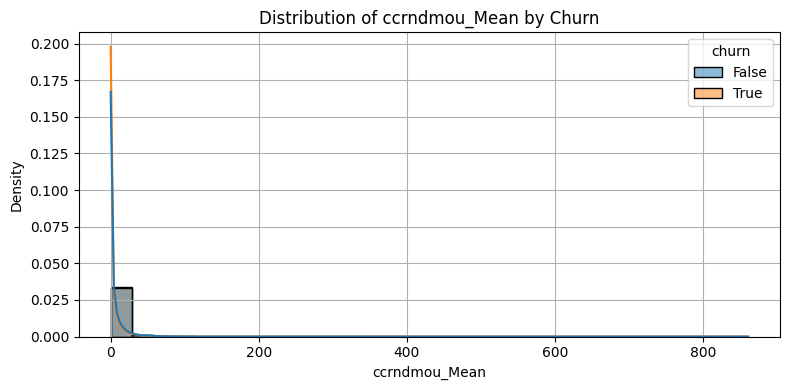

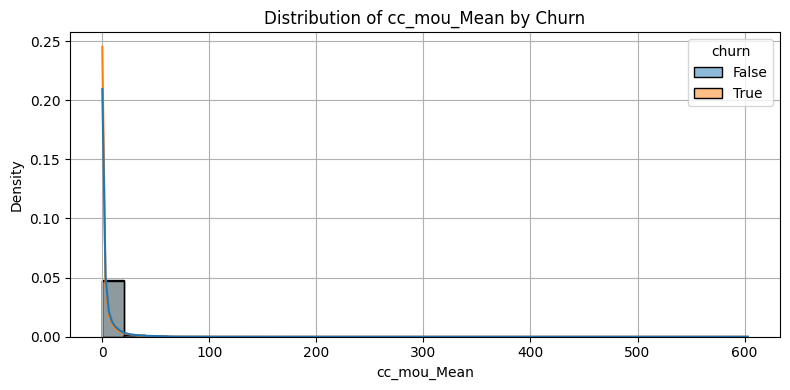

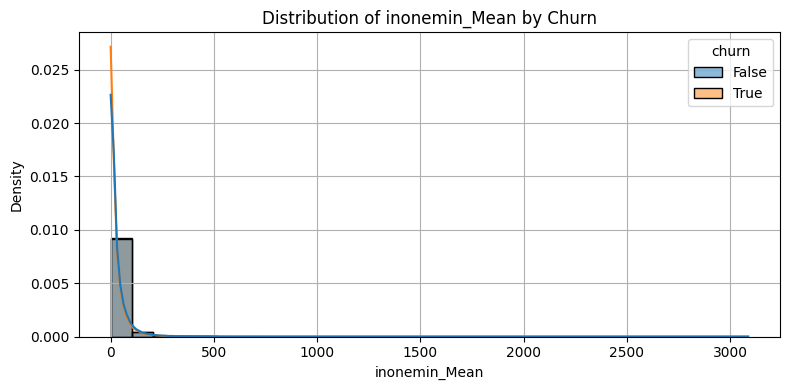

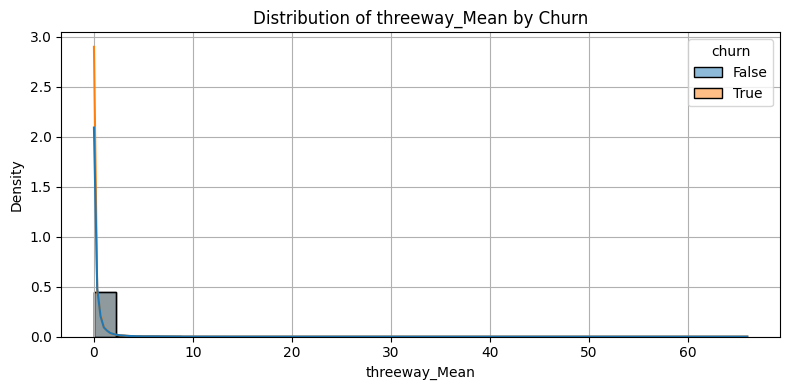

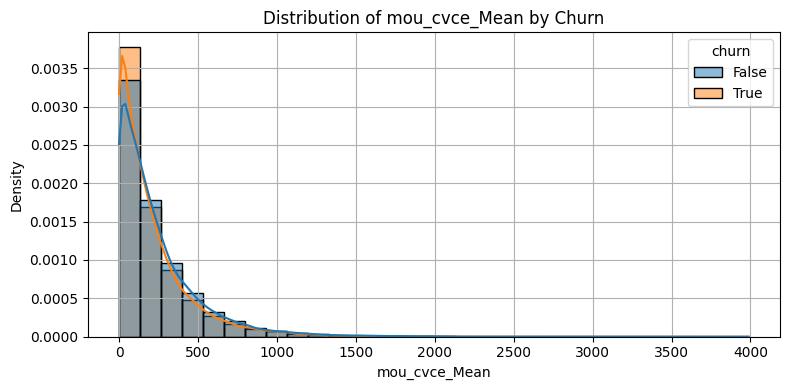

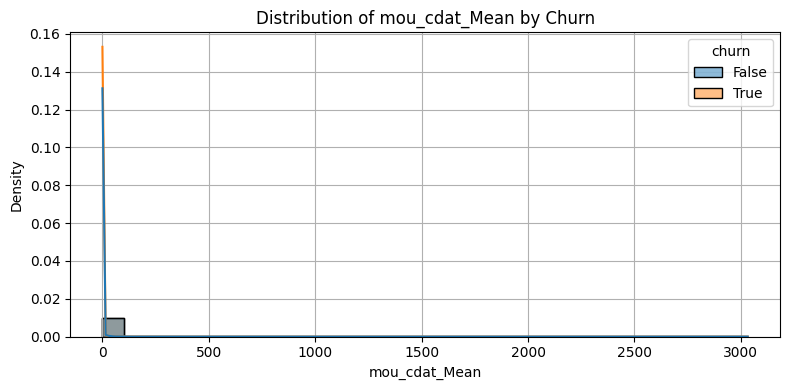

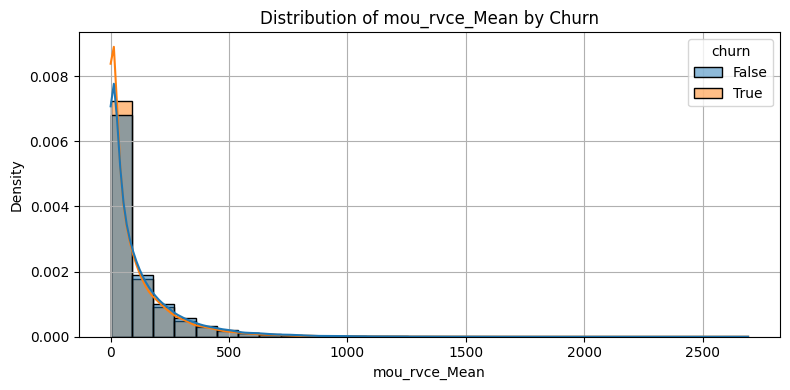

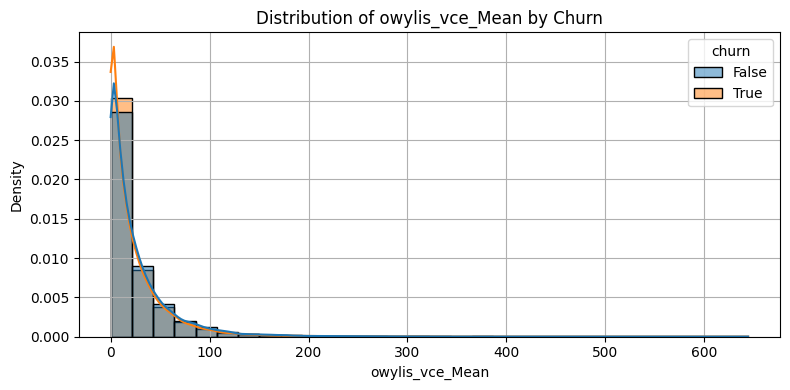

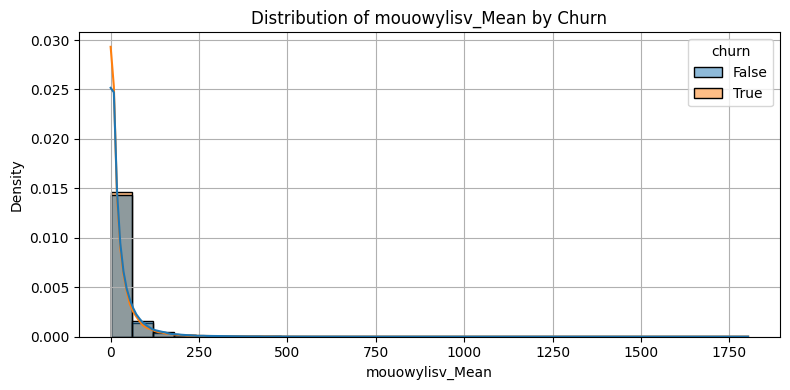

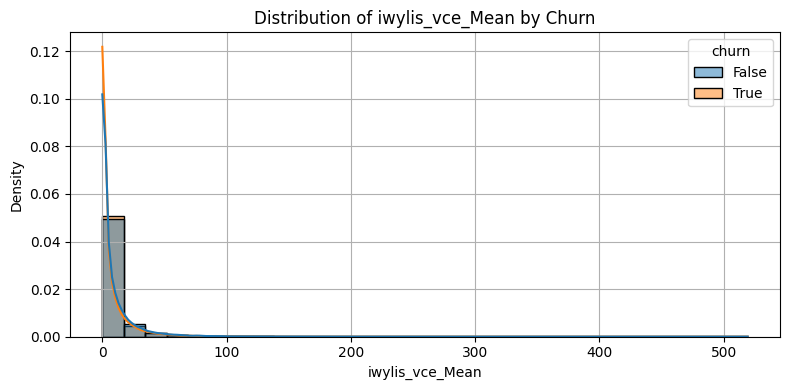

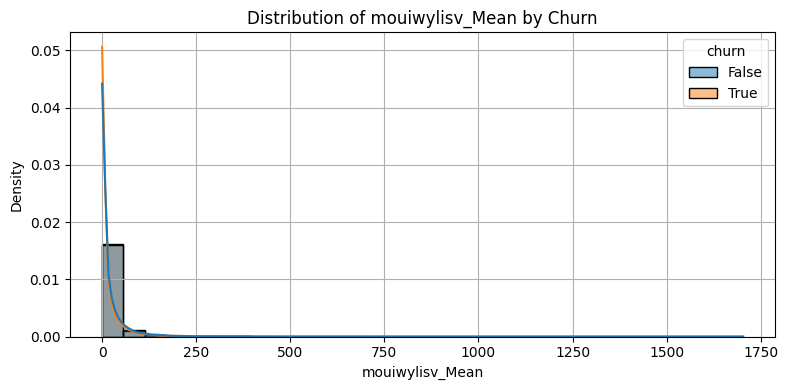

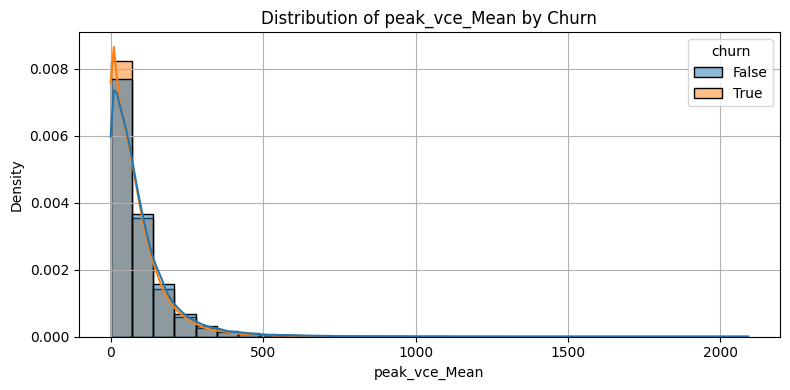

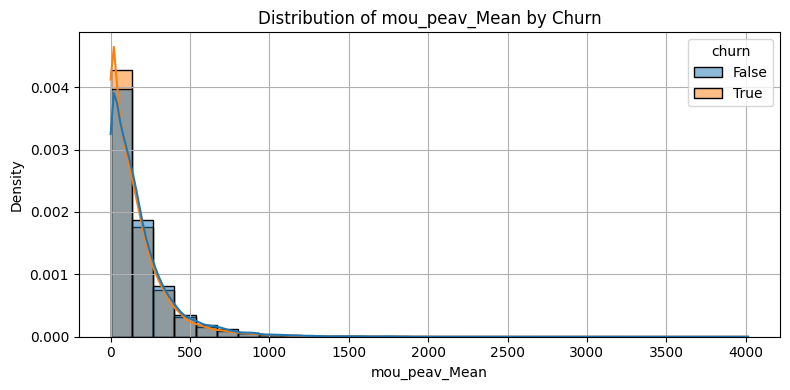

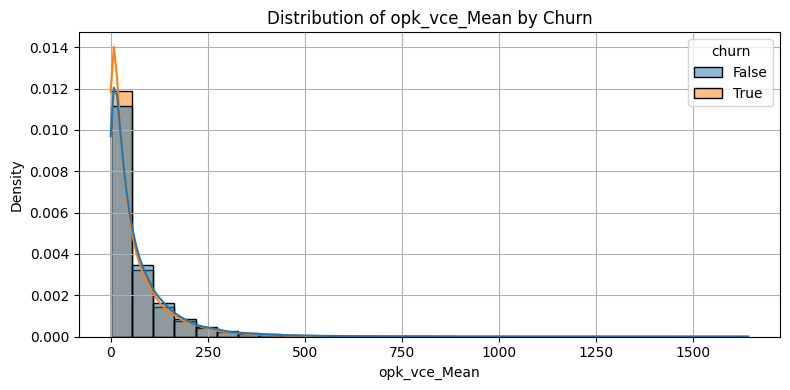

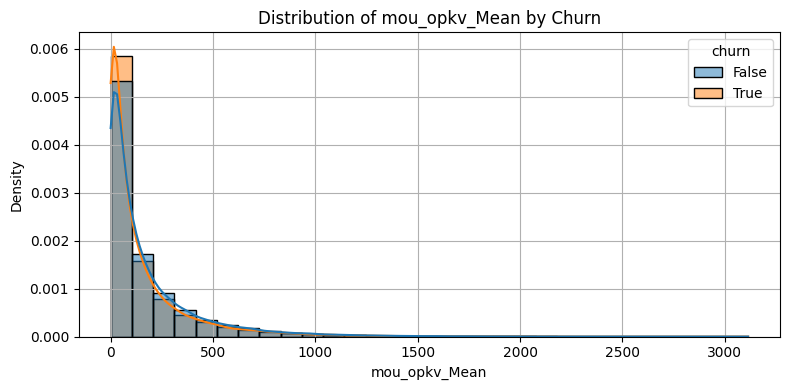

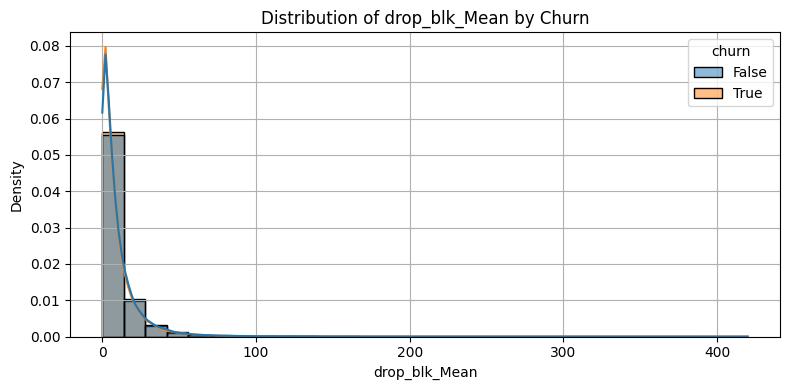

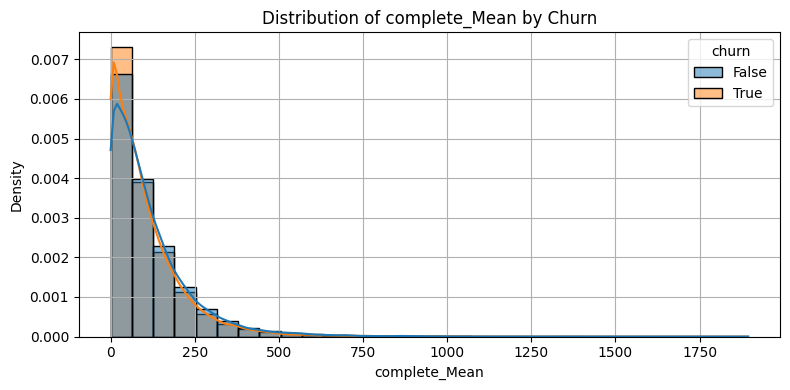

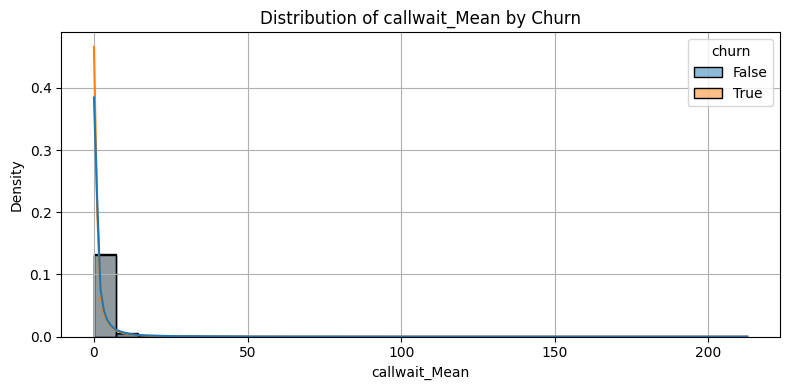

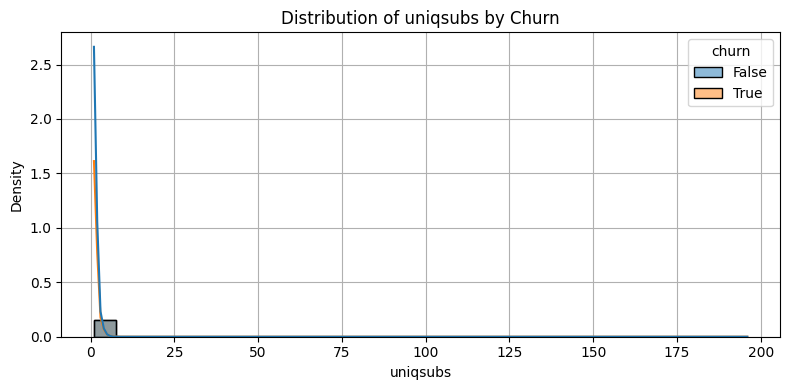

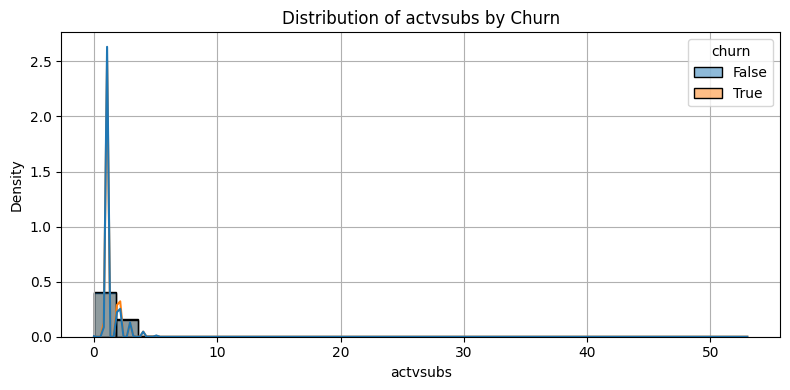

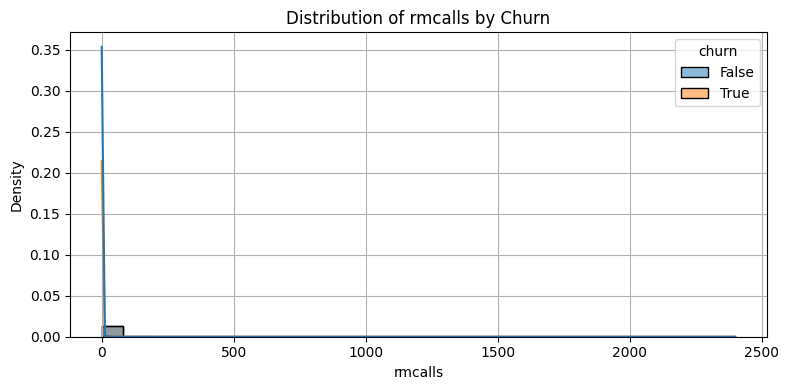

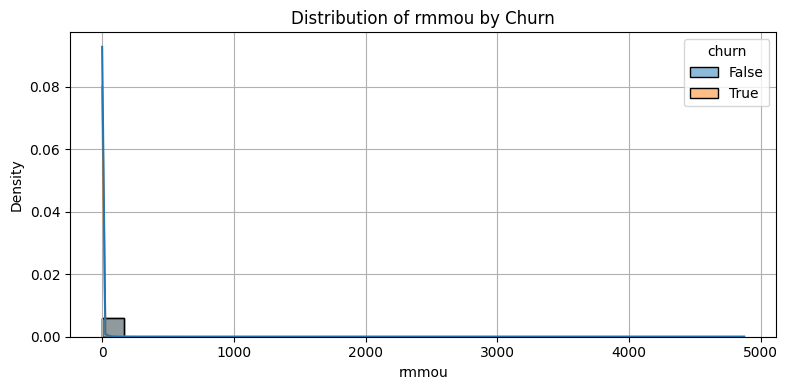

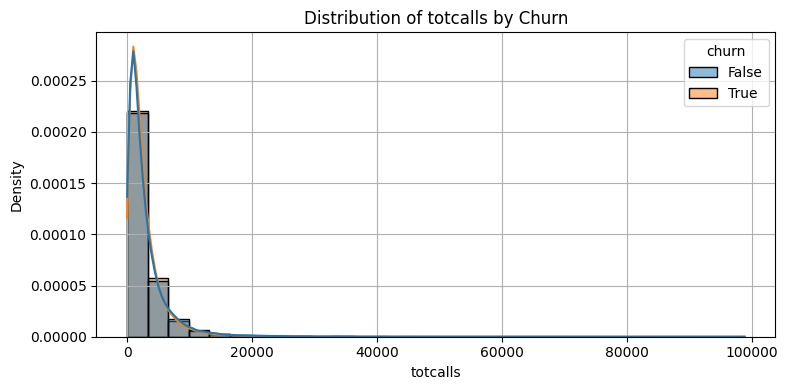

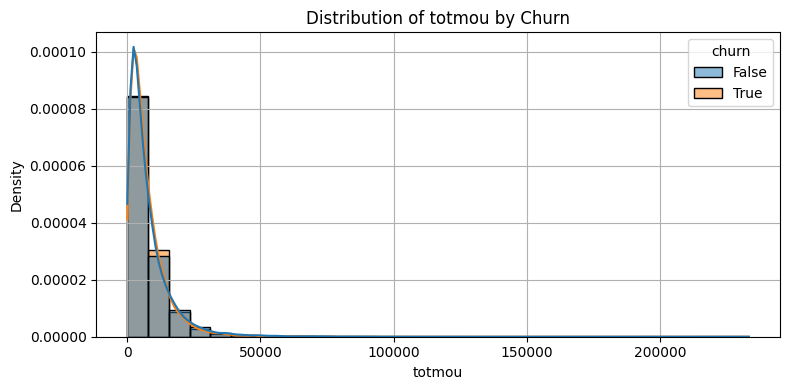

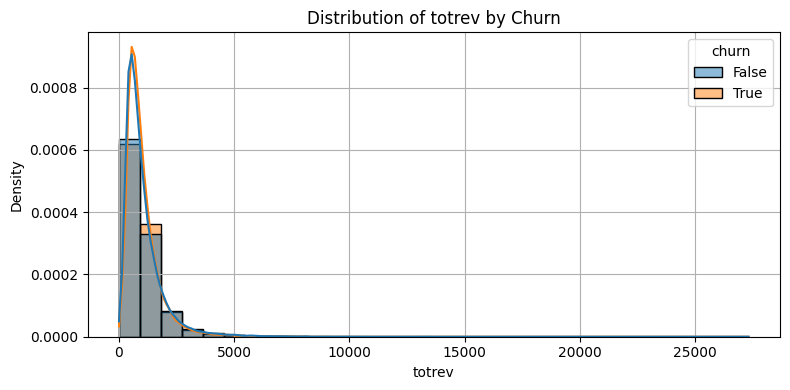

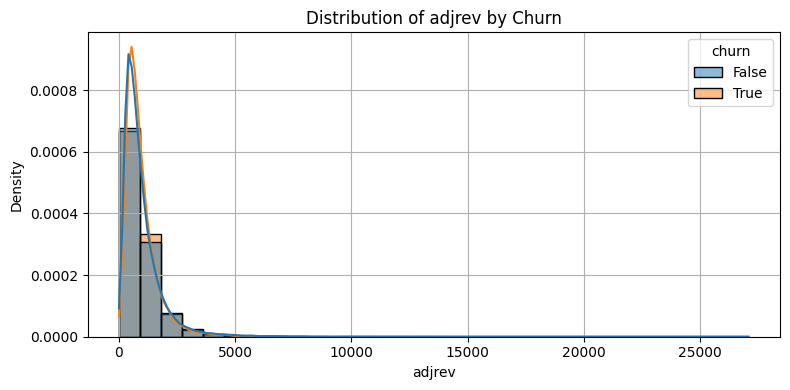

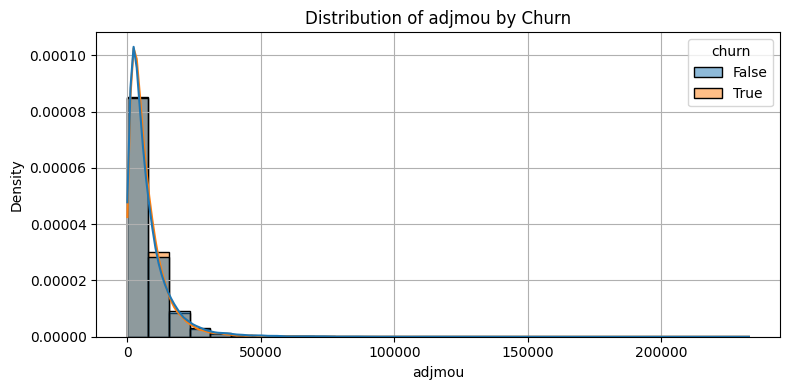

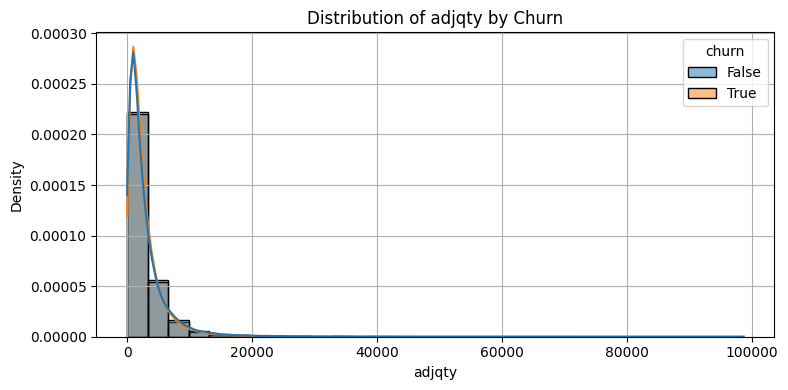

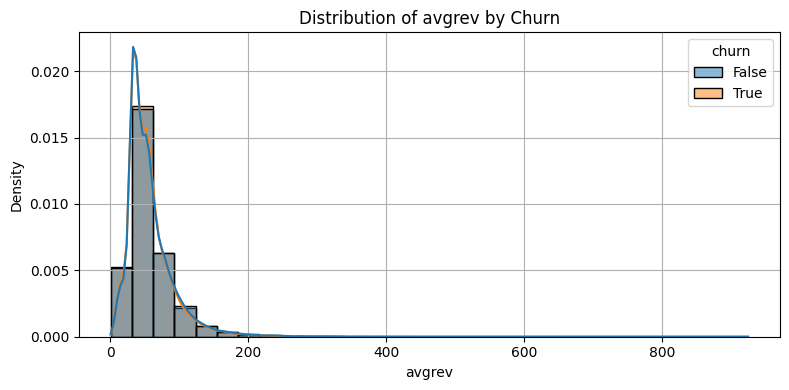

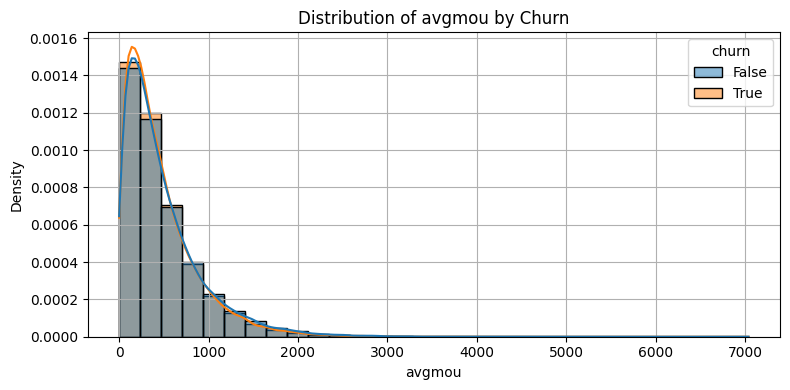

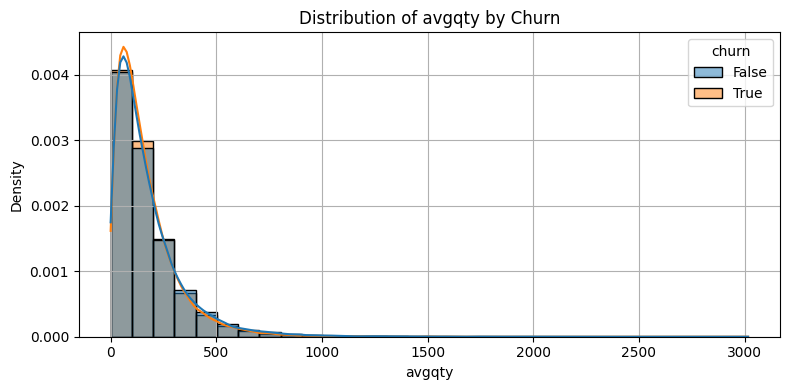

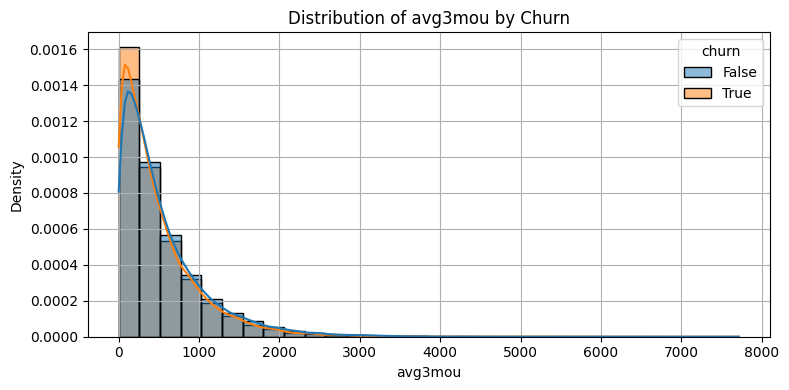

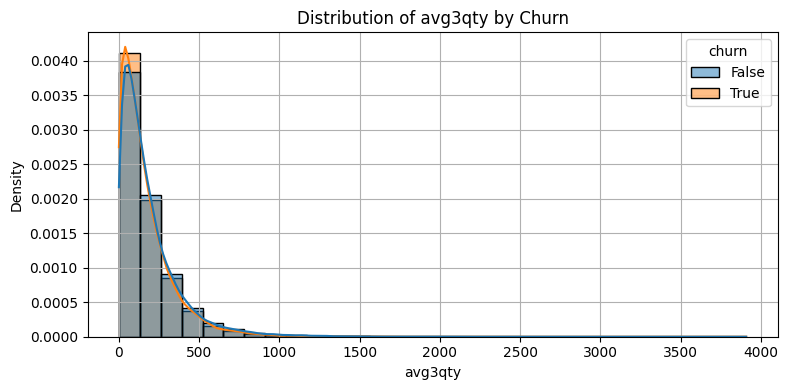

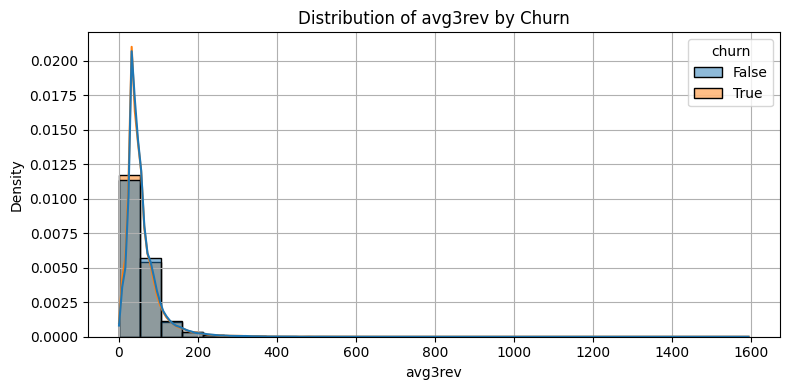

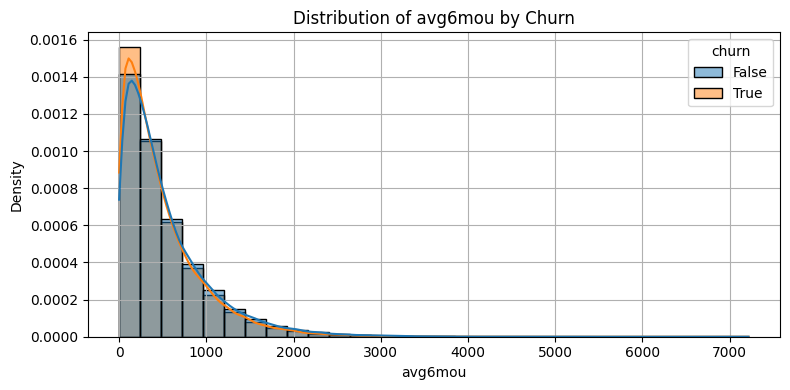

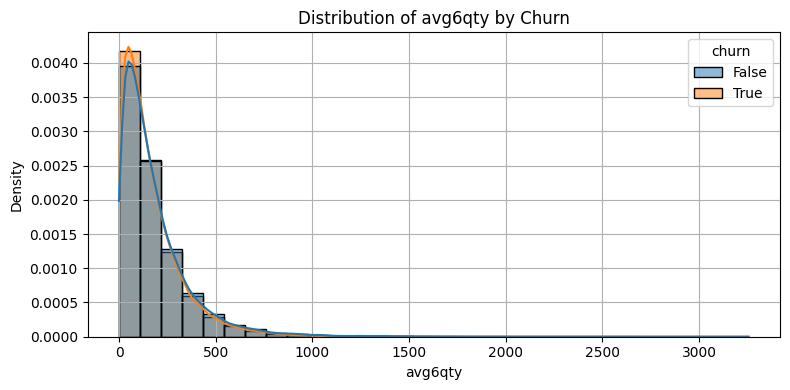

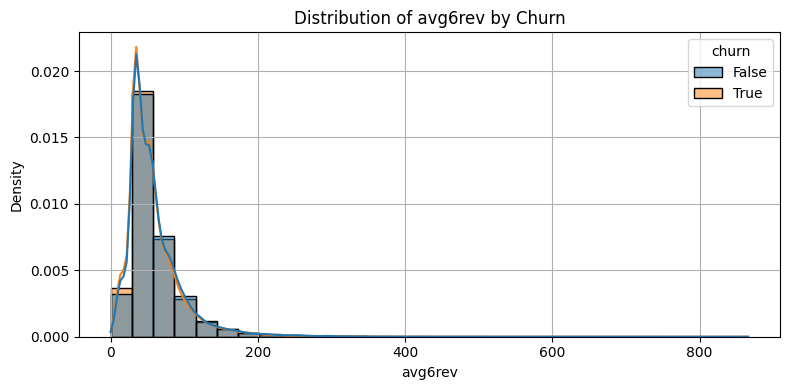

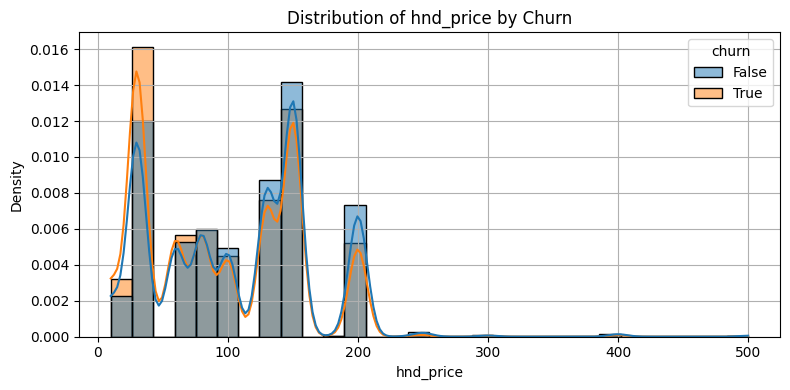

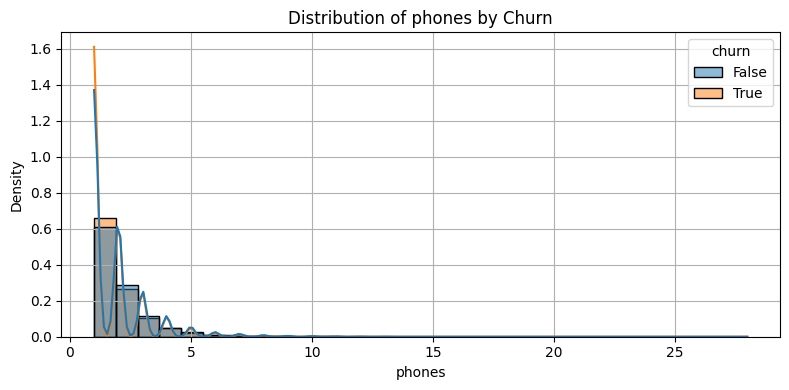

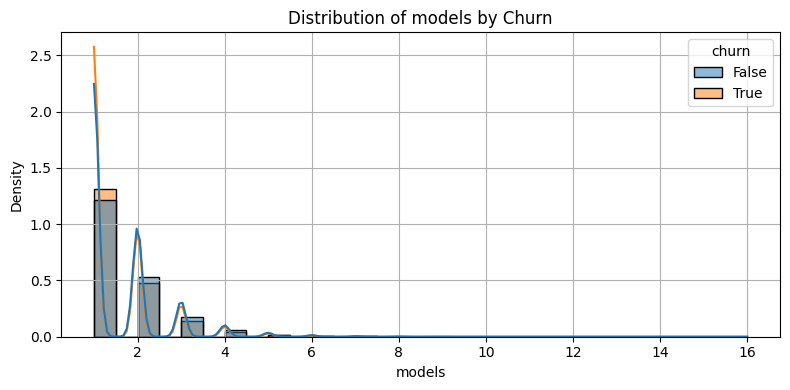

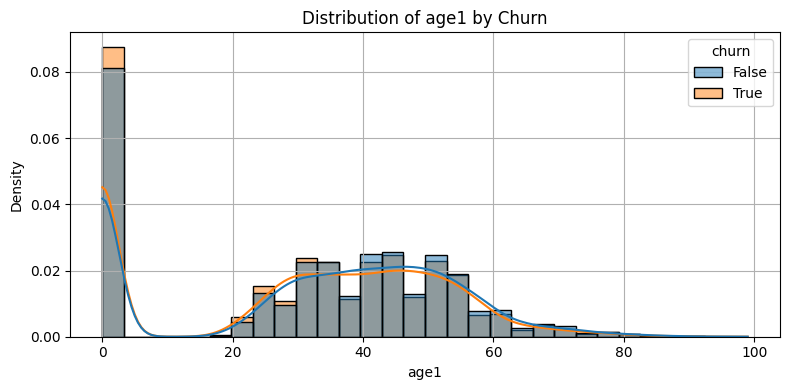

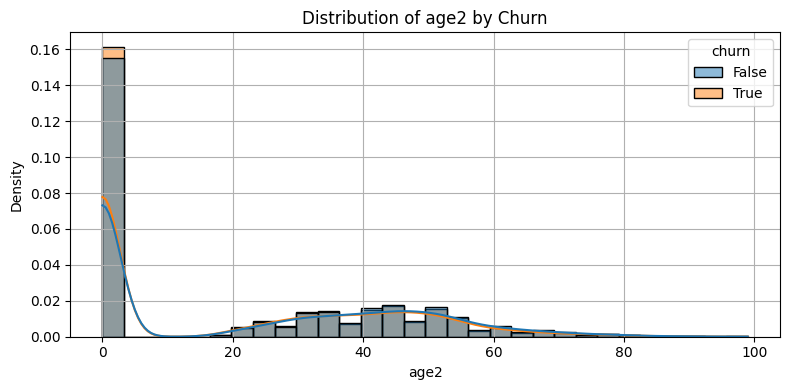

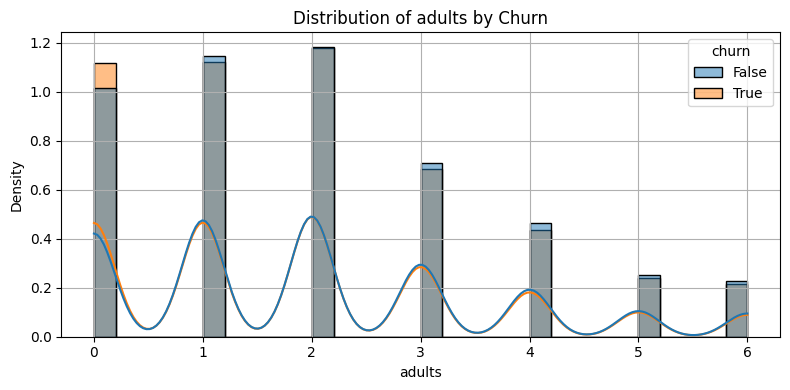

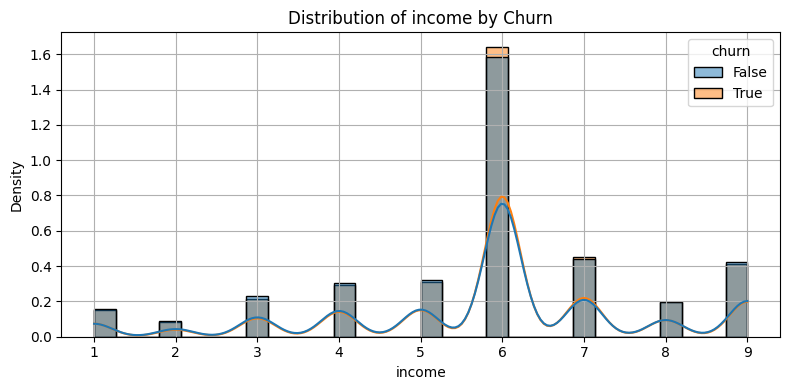

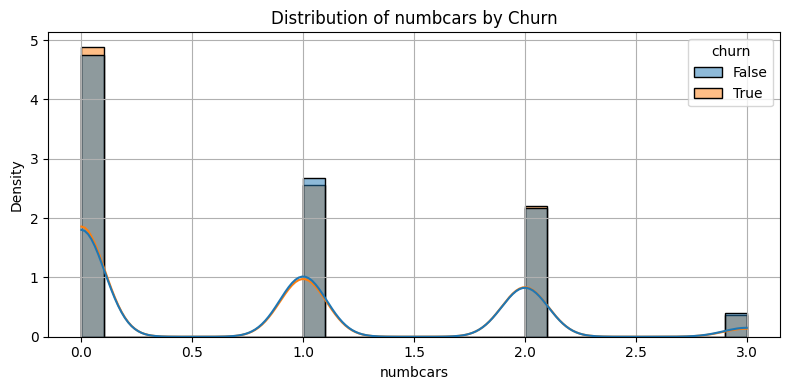

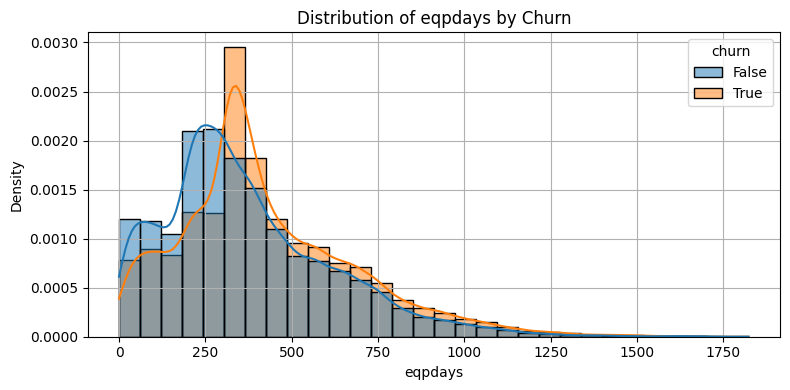

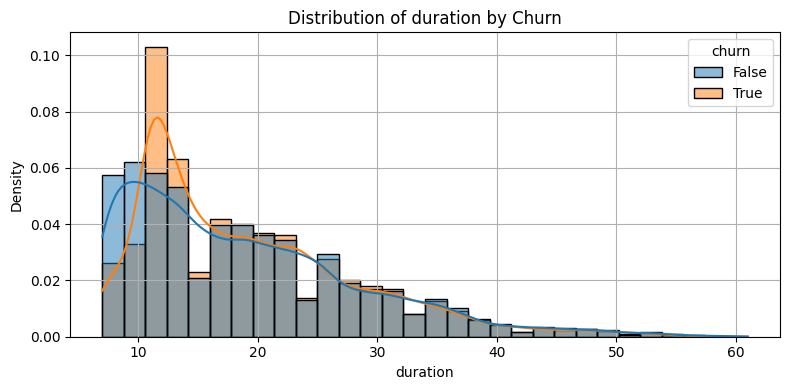

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numerical columns excluding ID and months (used as duration)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['Customer_ID', 'months']]

# Plot histograms of numerical variables grouped by churn
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, hue='churn', kde=True, stat='density', common_norm=False, bins=30)
    plt.title(f'Distribution of {col} by Churn')
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93893 entries, 0 to 93892
Columns: 108 entries, rev_Mean to mailresp_binary
dtypes: bool(23), float64(57), int64(9), object(19)
memory usage: 62.9+ MB


In [16]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df.columns

Index(['rev_Mean', 'mou_Mean', 'totmrc_Mean', 'da_Mean', 'ovrmou_Mean',
       'ovrrev_Mean', 'vceovr_Mean', 'datovr_Mean', 'roam_Mean', 'change_mou',
       ...
       'Customer_ID', 'mail', 'phoneswap', 'retentioncall', 'acptcall',
       'referrals', 'pcowner_binary', 'women', 'mailordr_binary',
       'mailresp_binary'],
      dtype='object', length=108)

In [17]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from kmodes.kprototypes import KPrototypes


# Drop columns not used for clustering
df_clustering = df.drop(columns=['Customer_ID', 'churn'])

# Identify types of features
bool_columns = df_clustering.select_dtypes(include='bool').columns.tolist()
num_columns = df_clustering.select_dtypes(include=['int64', 'float64']).columns.tolist()
obj_columns = df_clustering.select_dtypes(include='object').columns.tolist()

# Full list of categorical columns
categorical_columns = bool_columns + obj_columns

# Convert boolean and object columns to string (for consistency in clustering)
df_clustering[categorical_columns] = df_clustering[categorical_columns].astype(str)

# Standardize numerical columns
scaler = StandardScaler()
df_clustering[num_columns] = scaler.fit_transform(df_clustering[num_columns])

# Convert DataFrame to matrix for clustering
data_matrix = df_clustering.to_numpy()

# Get categorical indices for KPrototypes
categorical_indices = [df_clustering.columns.get_loc(col) for col in categorical_columns]

# Apply K-Prototypes with speed optimization
kproto = KPrototypes(n_clusters=4, init='Cao', verbose=1, max_iter=20, n_init=1)
clusters = kproto.fit_predict(data_matrix, categorical=categorical_indices)

# Assign clusters to original DataFrame
df['cluster'] = clusters

# Save the result to a new CSV
df.to_csv('Churn_Data_with_Clusters.csv', index=False)

# Display sample results
print(df[['Customer_ID', 'cluster']].head())


Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/20, moves: 45281, ncost: 4599217.872459889
Run: 1, iteration: 2/20, moves: 10768, ncost: 4552949.603136309
Run: 1, iteration: 3/20, moves: 4226, ncost: 4538104.246951944
Run: 1, iteration: 4/20, moves: 2333, ncost: 4532041.859216946
Run: 1, iteration: 5/20, moves: 2229, ncost: 4528329.26743766
Run: 1, iteration: 6/20, moves: 1736, ncost: 4526071.457041369
Run: 1, iteration: 7/20, moves: 1489, ncost: 4524726.321115901
Run: 1, iteration: 8/20, moves: 1243, ncost: 4523799.770993528
Run: 1, iteration: 9/20, moves: 1068, ncost: 4523089.142692263
Run: 1, iteration: 10/20, moves: 1191, ncost: 4522127.0096345935
Run: 1, iteration: 11/20, moves: 1227, ncost: 4521354.271735284
Run: 1, iteration: 12/20, moves: 941, ncost: 4520775.915469941
Run: 1, iteration: 13/20, moves: 767, ncost: 4520454.532054342
Run: 1, iteration: 14

In [22]:
# Compute differences in means and p-values (t-tests)
results = []
for col in numerical_cols:
    churned = df_numeric[df_numeric['churn'] == 1][col]
    not_churned = df_numeric[df_numeric['churn'] == 0][col]
    stat, pval = ttest_ind(churned, not_churned, equal_var=False)
    mean_diff = churned.mean() - not_churned.mean()
    results.append((col, mean_diff, pval))

# Create DataFrame of results
importance_df = pd.DataFrame(results, columns=['Feature', 'Mean_Diff', 'P_Value'])
importance_df['Abs_Mean_Diff'] = importance_df['Mean_Diff'].abs()
importance_df.sort_values(by='Abs_Mean_Diff', ascending=False, inplace=True)

# Display top variables
print("Top numerical features by absolute mean difference:")
print(importance_df[['Feature', 'Mean_Diff', 'P_Value']].head(10))

Top numerical features by absolute mean difference:
          Feature   Mean_Diff        P_Value
44         adjmou -374.754433   2.737942e-11
41         totmou -367.424091   9.443496e-11
45         adjqty -147.536499   1.996776e-09
40       totcalls -145.151631   4.990547e-09
1        mou_Mean  -61.176512   1.491117e-72
49        avg3mou  -55.205534   1.342222e-57
63        eqpdays   54.945952  9.002181e-241
52        avg6mou  -45.165349   1.314729e-44
22  mou_cvce_Mean  -27.438414   7.159239e-58
32  mou_opkv_Mean  -22.779150   5.864123e-50


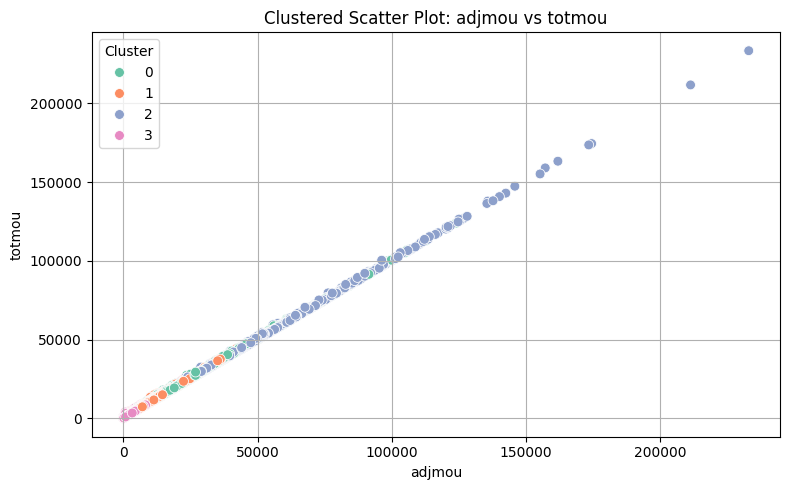

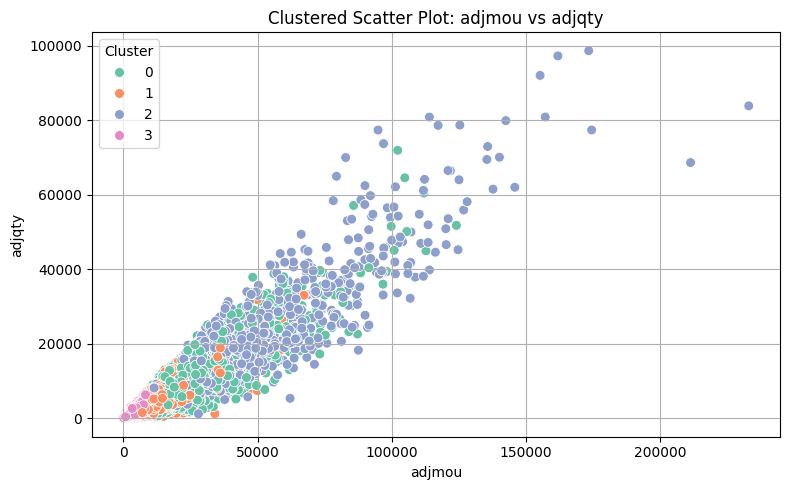

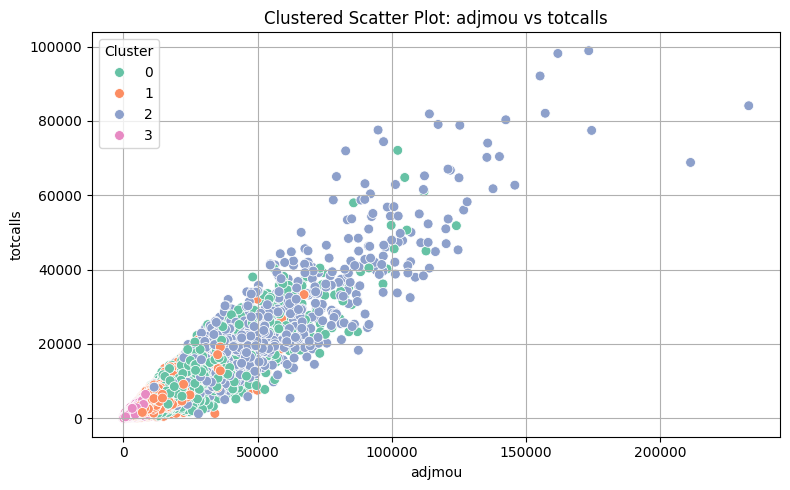

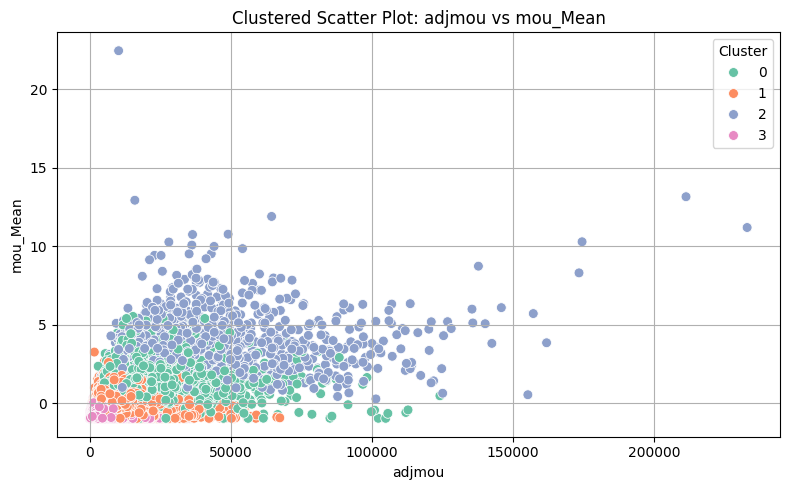

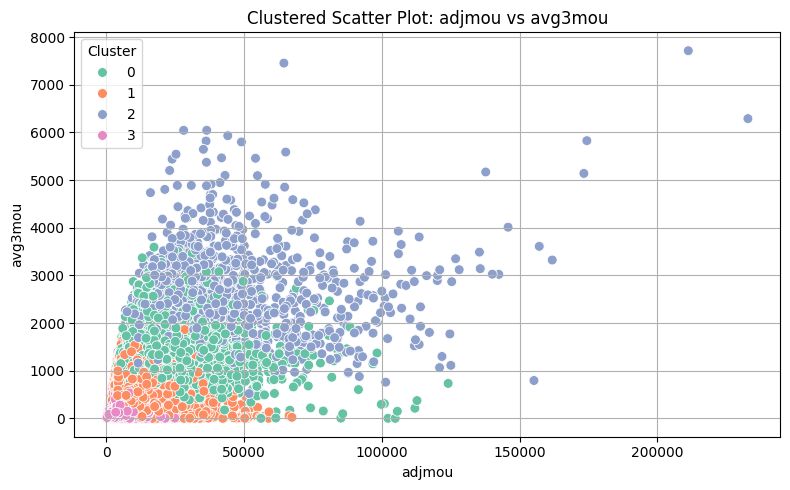

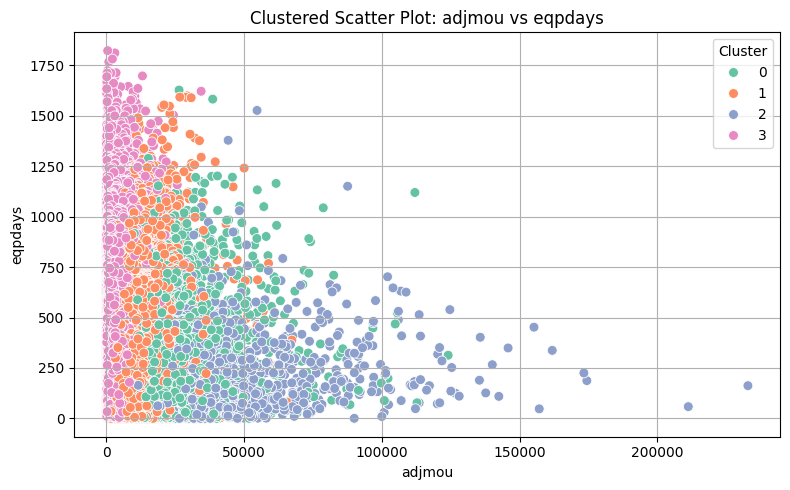

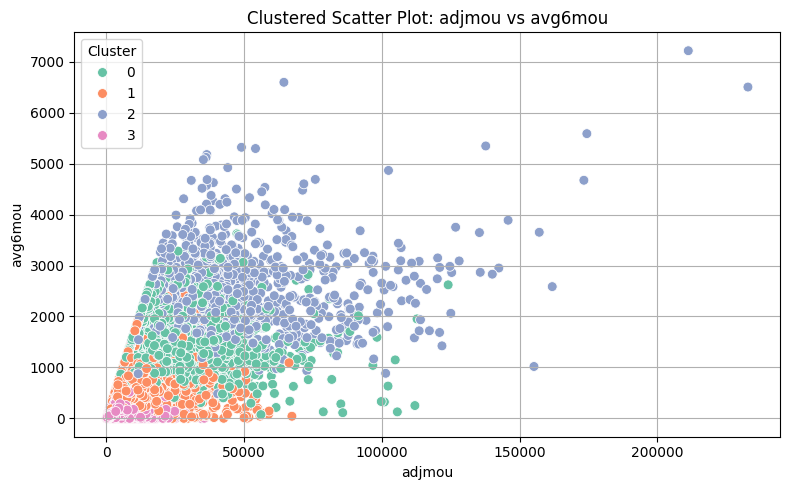

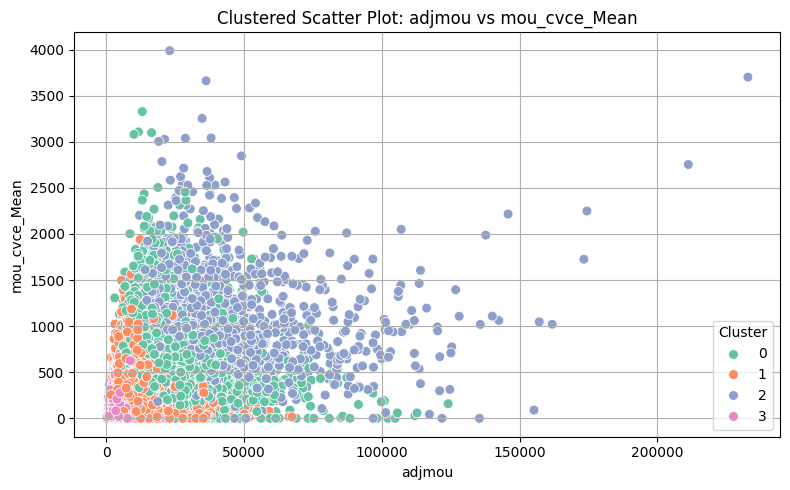

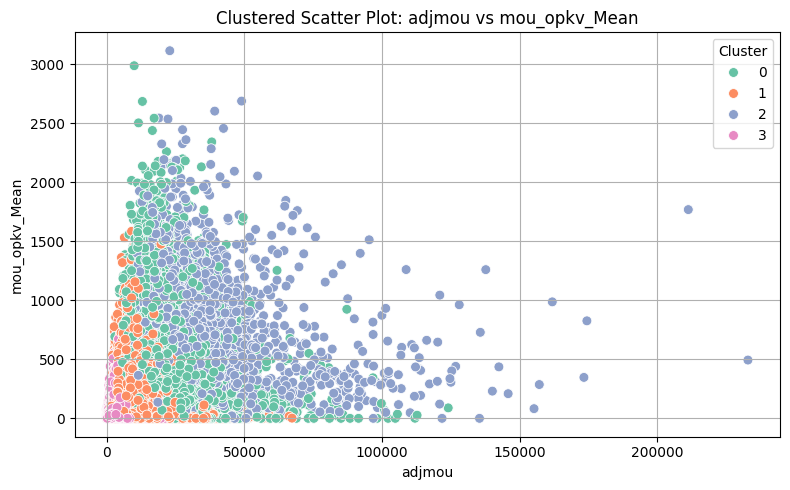

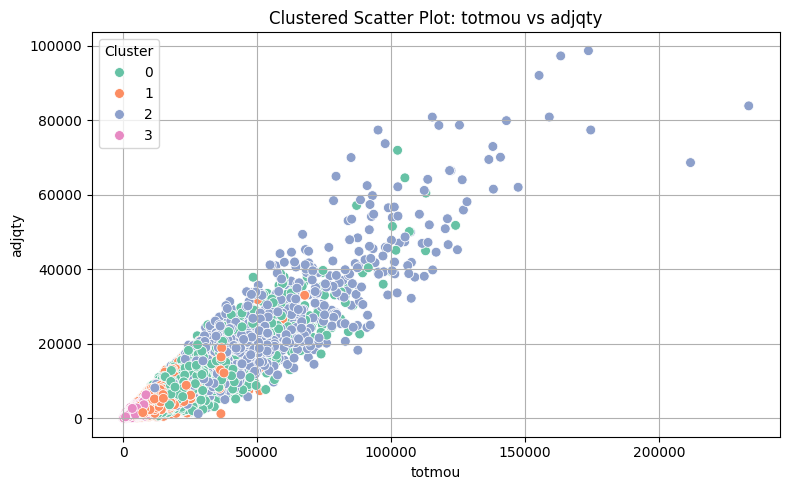

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# Top 10 features (from your image)
top_features = [
    'adjmou', 'totmou', 'adjqty', 'totcalls', 'mou_Mean',
    'avg3mou', 'eqpdays', 'avg6mou', 'mou_cvce_Mean', 'mou_opkv_Mean'
]

# Create scatter plots for all pairs (combinations of 2)
feature_pairs = list(combinations(top_features, 2))

# Limit to top 10 pairs to avoid overload
for x_var, y_var in feature_pairs[:10]:  # Change range to see more
    if x_var in df.columns and y_var in df.columns:
        plt.figure(figsize=(8, 5))
        sns.scatterplot(data=df, x=x_var, y=y_var, hue='cluster', palette='Set2', s=50)
        plt.title(f'Clustered Scatter Plot: {x_var} vs {y_var}')
        plt.xlabel(x_var)
        plt.ylabel(y_var)
        plt.grid(True)
        plt.legend(title='Cluster')
        plt.tight_layout()
        plt.show()


Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.994122071776161
            Iterations: 47
            Function evaluations: 65
            Gradient evaluations: 47
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 1.994122071776161
       x: [ 2.130e+00 -2.876e+00 ...  2.720e+00  1.024e+00]
     nit: 47
     jac: [ 4.707e-06  3.235e-06 ...  4.225e-07 -4.936e-06]
    nfev: 65
    njev: 47


<lifelines.WeibullAFTFitter: fitted with 93893 total observations, 47177 right-censored observations>
             duration col = 'duration'
                event col = 'churn'
   number of observations = 93893
number of events observed = 46716
           log-likelihood = -187234.10
         time fit was run = 2025-05-22 19:54:03 UTC

---
                                            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                           
lambda_ adjmou                              0.00      1.00      0.00            0.00            0.00                1.00                1.00
        adjqty                             -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
        area_CALIFORNIA NORTH AREA          0.12      1.13      0.01            0.10            0.14                1.11                1.15
        area_CENTRAL/SOUTH TEXAS AREA       0.19      1.21      0.01            0.17            0.21                1.18                1.23
        area_CHICAGO AREA                   0.04      1.04      0.01            0.02            0.06                1.02                1.06
        area_DALLAS AREA                    0.19      1.21      0.01            0.17            0.21                1.19                1.24
        area_DC/MARYLAND/VIRGINIA AREA      0.09      1.10      0.01            0.07            0.11                1.08                1.12
        area_GREAT LAKES AREA               0.14      1.15      0.01            0.12            0.16                1.13                1.17
        area_HOUSTON AREA                   0.14      1.15      0.01            0.12            0.16                1.13                1.17
        area_LOS ANGELES AREA               0.25      1.28      0.01            0.23            0.26                1.25                1.30
        area_MIDWEST AREA                   0.20      1.22      0.01            0.18            0.22                1.20                1.24
        area_NEW ENGLAND AREA               0.10      1.11      0.01            0.08            0.12                1.09                1.13
        area_NEW YORK CITY AREA             0.12      1.13      0.01            0.10            0.14                1.11                1.14
        area_NORTH FLORIDA AREA             0.07      1.08      0.01            0.05            0.09                1.05                1.10
        area_NORTHWEST/ROCKY MOUNTAIN AREA  0.12      1.13      0.01            0.10            0.14                1.11                1.15
        area_OHIO AREA                      0.11      1.11      0.01            0.09            0.13                1.09                1.14
        area_PHILADELPHIA AREA              0.09      1.10      0.01            0.07            0.12                1.07                1.13
        area_SOUTH FLORIDA AREA             0.12      1.13      0.01            0.10            0.14                1.10                1.15
        area_SOUTHWEST AREA                 0.29      1.34      0.01            0.27            0.31                1.32                1.37
        area_TENNESSEE AREA                 0.18      1.20      0.01            0.15            0.20                1.17                1.23
        mailresp_binary                     0.10      1.10      0.00            0.09            0.10                1.09                1.11
        pcowner_binary                      0.05      1.05      0.00            0.04            0.06                1.04                1.06
        totcalls                            0.00      1.00      0.00            0.00            0.00                1.00                1.00
        totmou                             -0.00      1.00      0.00           -0.00           -0.00                1.00              

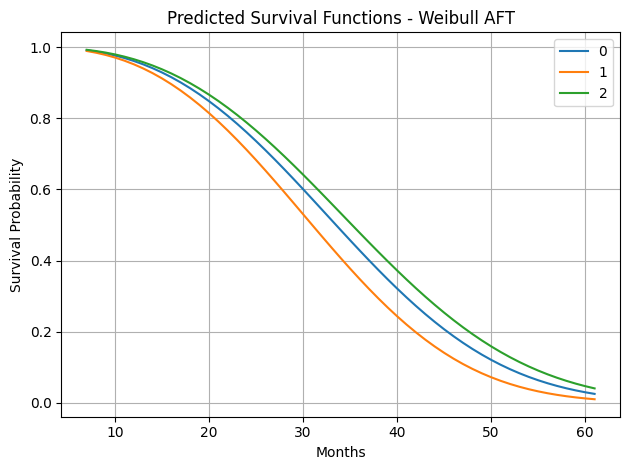

In [23]:
import pandas as pd
import numpy as np
from lifelines import WeibullAFTFitter
import matplotlib.pyplot as plt
import seaborn as sns

# --- Step 1: Use 'months' as the duration ---
df['duration'] = df['months']

# --- Step 2: Select numerical columns and drop ID & duration ---
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols = [col for col in numerical_cols if col not in ['Customer_ID', 'months', 'duration']]

# --- Step 3: Choose top predictors by variance ---
top_numeric_vars = df[numerical_cols].var().sort_values(ascending=False).head(5).index.tolist()

# --- Step 4: Add some key categorical or binary features manually ---
key_binary_features = ['pcowner_binary', 'mailresp_binary']
categorical_cols = ['area'] if 'area' in df.columns else []  # Adjust based on your data

# Final list of predictors
features = top_numeric_vars + key_binary_features + categorical_cols + ['churn', 'duration']

# Subset and preprocess
df_model = df[features].copy()

# Convert booleans to integers
bool_cols = df_model.select_dtypes(include='bool').columns
df_model[bool_cols] = df_model[bool_cols].astype(int)

# One-hot encode categorical variables
df_model = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# --- Step 5: Fit Weibull AFT model ---
aft = WeibullAFTFitter()
aft.fit(df_model, duration_col='duration', event_col='churn', show_progress=True)

# --- Step 6: Model summary ---
aft.print_summary()

# --- Step 7: Visualize survival function for first few customers ---
aft.predict_survival_function(df_model.iloc[:3]).plot()
plt.title("Predicted Survival Functions - Weibull AFT")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.show()
